In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

In [2]:
####################### Camera Calibration ############################
nx = 9#TODO: enter the number of inside corners in x, horizontal
ny = 6#TODO: enter the number of inside corners in y, vertical
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
cal_dir = "camera_cal/"
cal_output_dir = "camera_cal_output/"

# Step through the list and search for chessboard corners
for index, img_name in enumerate(os.listdir(cal_dir)):
    image = cv2.imread(cal_dir + img_name) #BGR format
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        corner_img = cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        cv2.imwrite(cal_output_dir + "marked_" + img_name,corner_img)    

# Do camera calibration given object points and image points
img = cv2.imread('./camera_cal/calibration01.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

sample_no = 20;
col = 2;
# Run undistortion on an image
for index, img_name in enumerate(os.listdir(cal_dir)):
    image = cv2.imread(cal_dir + img_name) #BGR format
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite(cal_output_dir + "undistort_" + img_name, undistort_img)

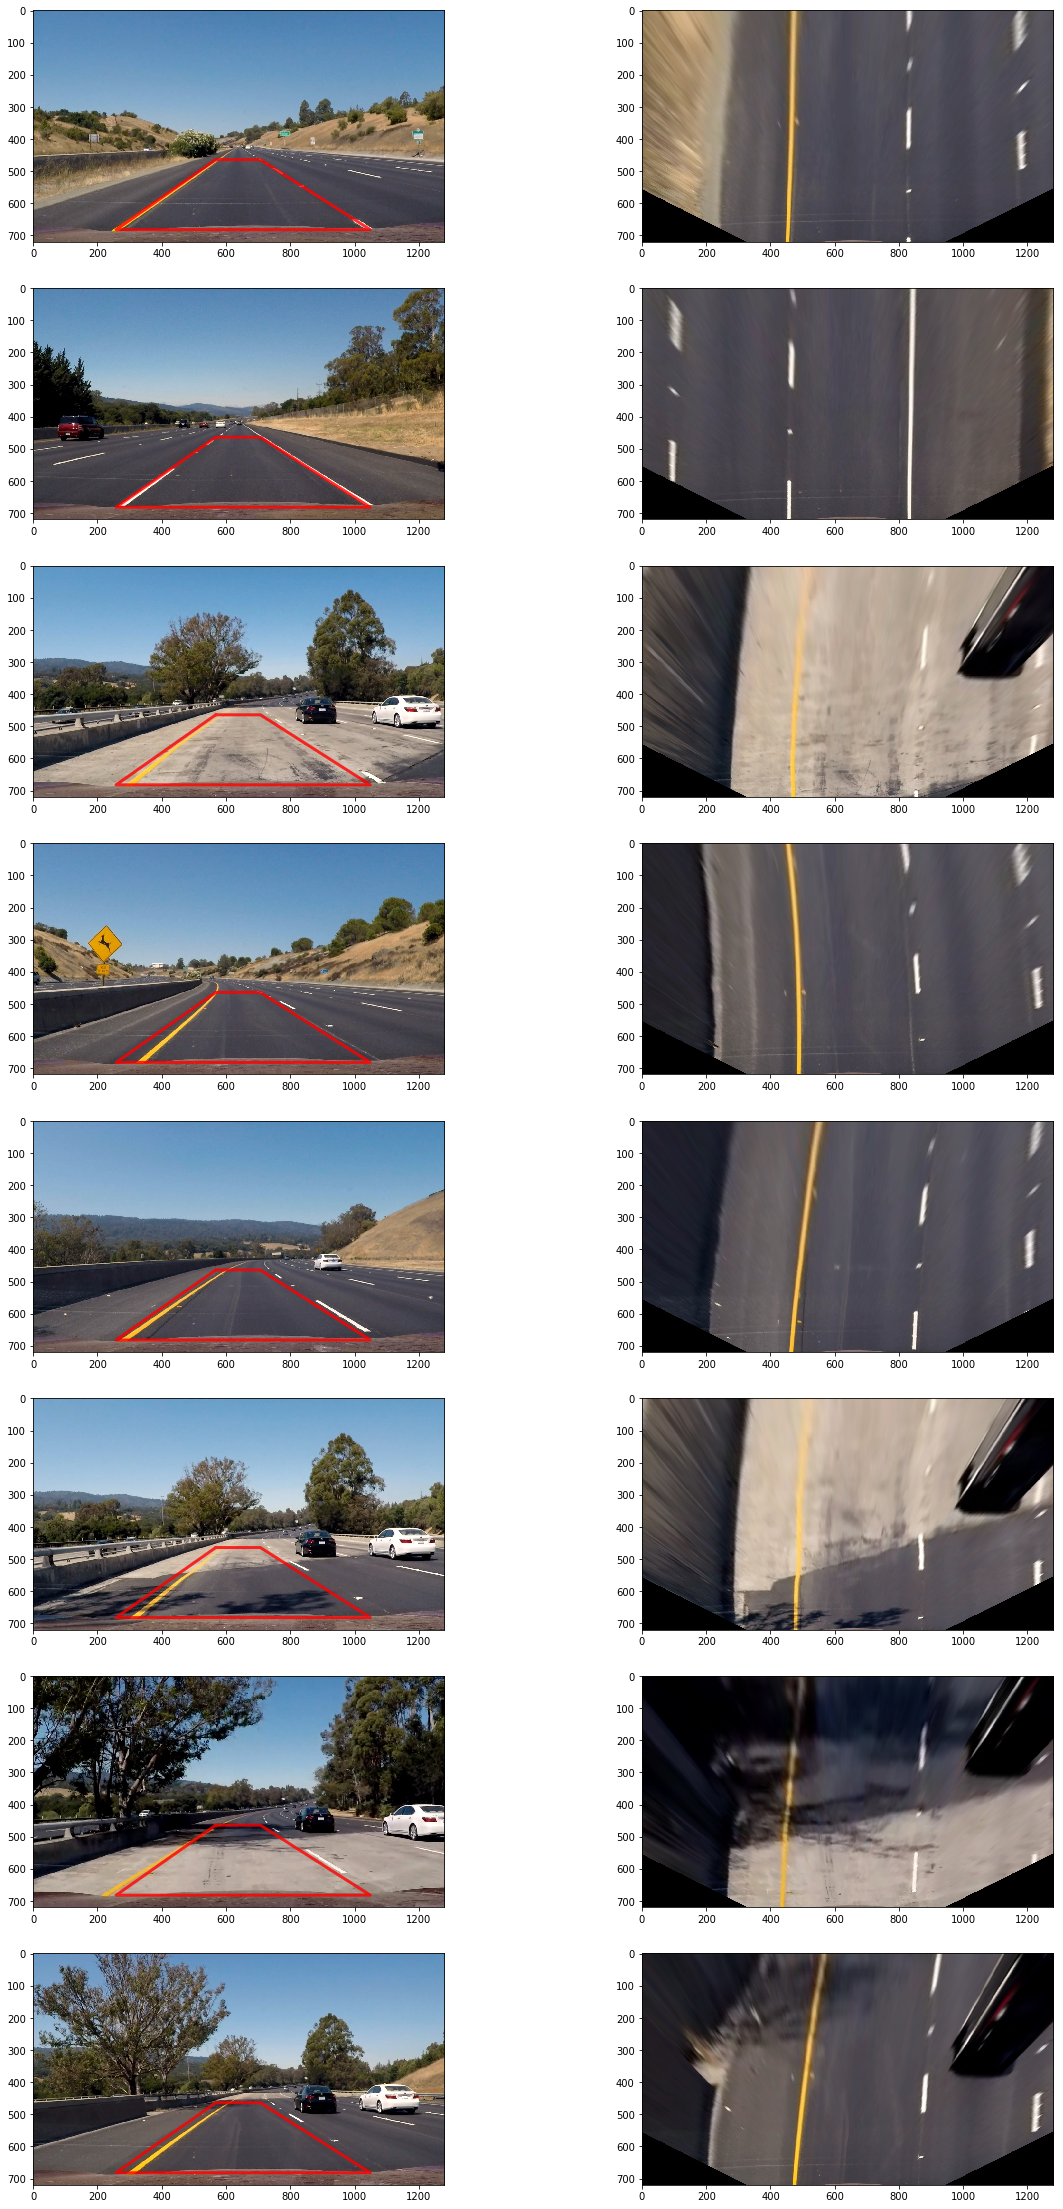

In [3]:
####################### Perspective Transform ############################
def BRG2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def GRAY(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Input is undistorted image, src, dst transform matrix
def corners_unwarp(image, src, dst):
    # Obtain height & width
    h,w = image.shape[:2]
    # Get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Get M_inv, the inverse transform matrix
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp image to a topdown view
    warped = cv2.warpPerspective(image, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv


# Read camera calibration coefficients
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define transform matrix
test_images_output_dir = "test_images_output/"
test_images_dir = "test_images/"
img = cv2.imread('./test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
w,h = img_size
src = np.float32([(568,464),
          (707,464), 
          (258,682), 
          (1049,682)])
dst = np.float32([(450,0),
          (w-450,0),
          (450,h),
          (w-450,h)])

# Visualize wrapped area
sample_no = len(os.listdir(test_images_dir));
col = 2;
plt.figure(figsize=[20,40])
for index, img_name in enumerate(os.listdir(test_images_dir)):
    image = cv2.imread(test_images_dir + img_name) #BGR format
    plt.subplot(sample_no,col,index*col+1)
    
    plt.imshow(BRG2RGB(image))
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    plt.plot(x, y, color='r', alpha=0.8, linewidth=3, solid_capstyle='round', zorder=2)
    
    plt.subplot(sample_no,col,index*col+2)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    topdown_img, perspective_M, M_inv = corners_unwarp(undistort_img, src, dst)
    plt.imshow(BRG2RGB(topdown_img))  # show single color, call as plt.imshow(gray, cmap='gray')
    cv2.imwrite(test_images_output_dir + "topdown_" + img_name,topdown_img)

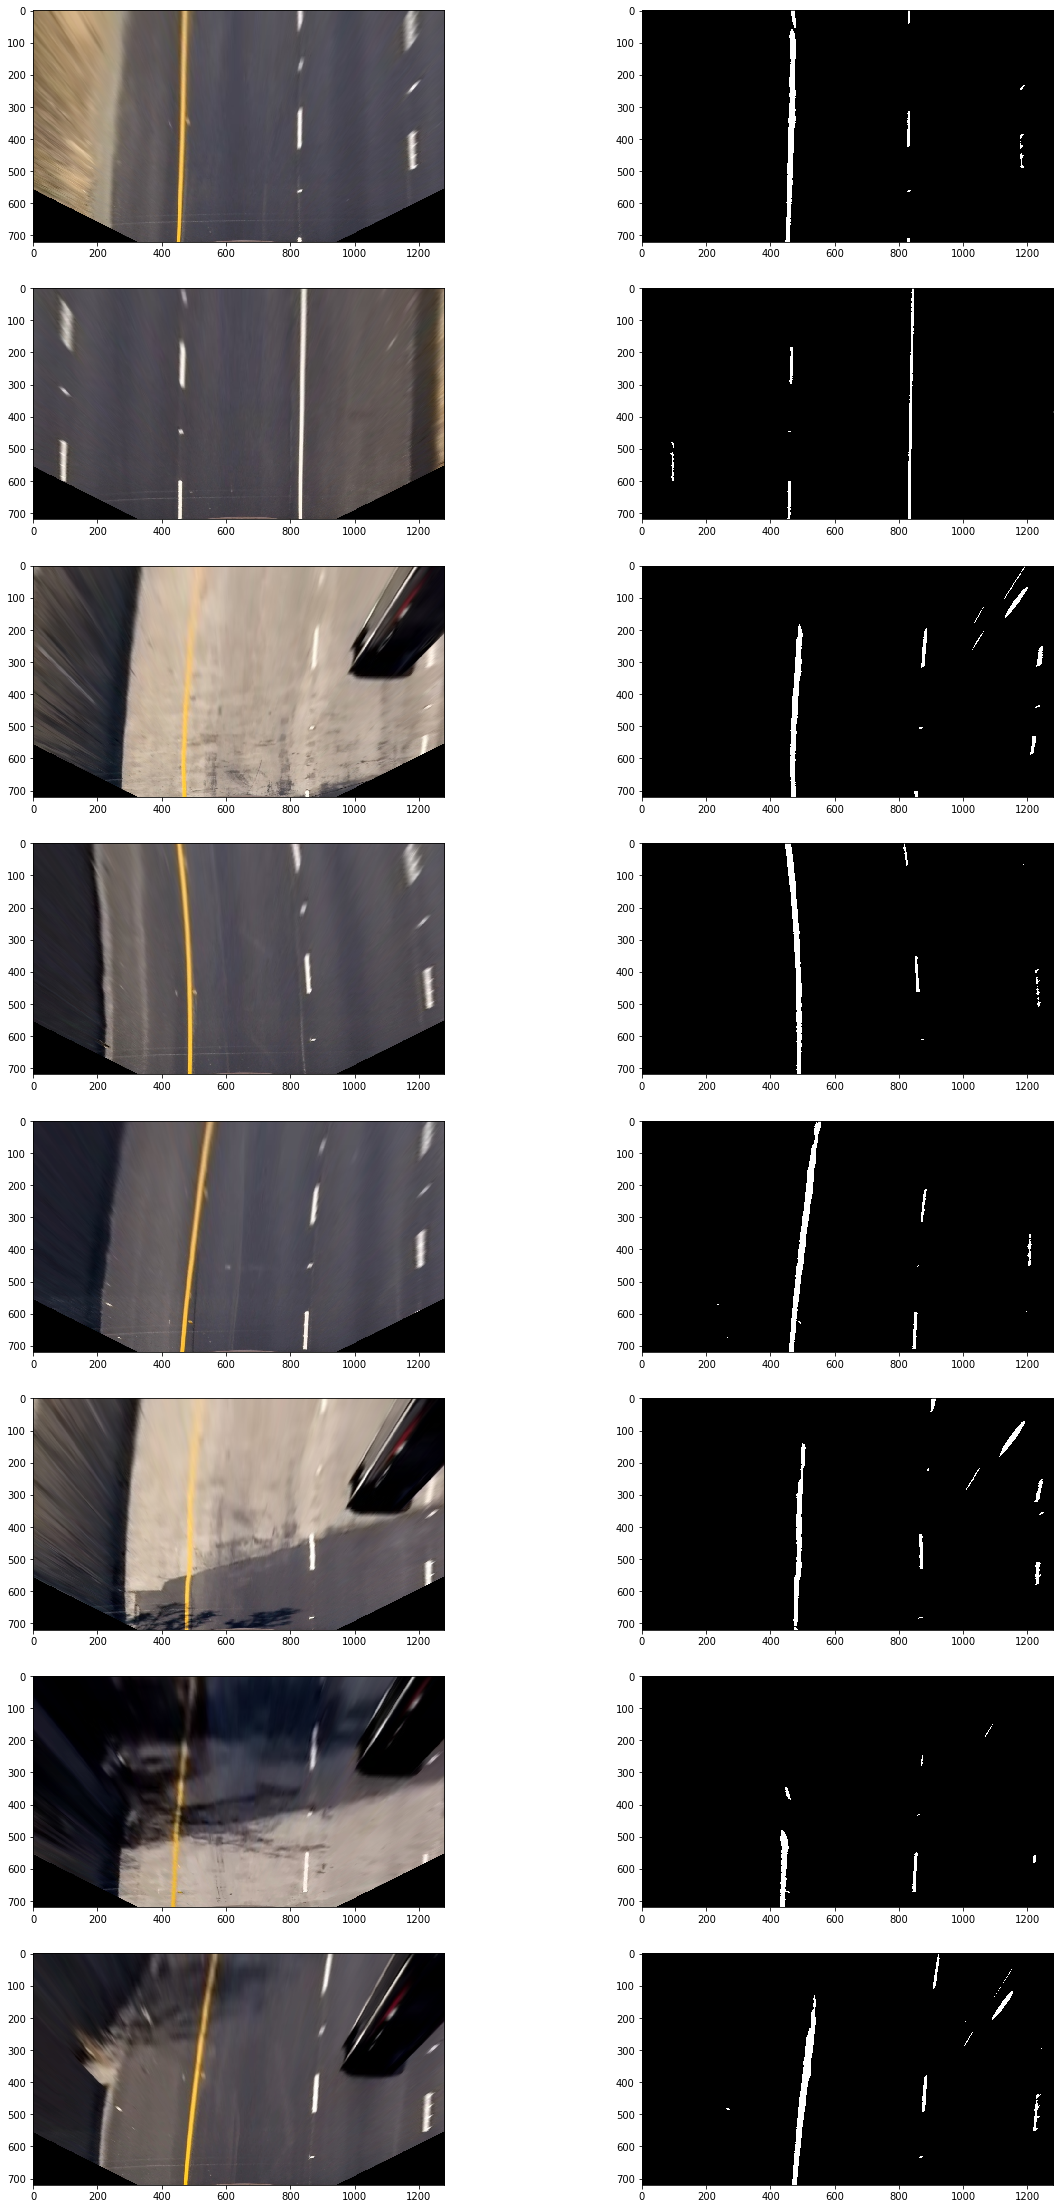

In [16]:
####################### Laneline Detection ############################
def BGR2HLS(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

def BGR2LAB(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# input: topdown_img in BGR format
#option: abs, mag, dir
def sobel_threshold(image, option, blur_en):
    gray_img = GRAY(image)
    if 1 == blur_en:
        gray_img = gaussian_blur(gray_img,3)
        
    if "abs" == option:
        # filter param
        x_y_dir = (1,0) # choose x_dir
        # sobel in x_dir
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, x_y_dir[0], x_y_dir[1])
        # get abs and scale to uint8
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # obtain binary mask
        thresh = (25,255)
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output

    elif "mag" == option:
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
        # obtain binary mask
        thresh = (25,255)
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output
        
    elif "dir" == option:
        ksize = 7
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=ksize)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=ksize)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        grad_dir = np.arctan2(abs_sobely, abs_sobelx) # 0 --> pi/4
        # obtain binary mask
        grad_thresh = (0, np.pi/10) # 0 --> 180/10 deg
        binary_output =  np.zeros_like(grad_dir)
        binary_output[(grad_dir >= grad_thresh[0]) & (grad_dir <= grad_thresh[1])] = 1
        return binary_output

# input: topdown_img in BGR format
def combined_sobel_threshold(image):
    mag_img = sobel_threshold(image, "mag",0)
    dir_img = sobel_threshold(image, "dir",0)
    combined_img = np.zeros_like(mag_img)
    combined_img[(mag_img==1) & (dir_img==1)] = 1
    return combined_img

# input: topdown_img in BGR format
def hls_threshold(image):
    yellow_min_threshold = np.array([18,80,30])
    yellow_max_threshold = np.array([60,180,255])
    white_min_threshold = np.array([0,210,0])
    white_max_threshold = np.array([255,255,255])
    hls_img = BGR2HLS(image)
    white_mask = cv2.inRange(hls_img,white_min_threshold,white_max_threshold)
    yellow_mask = cv2.inRange(hls_img,yellow_min_threshold,yellow_max_threshold)   
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    return yellow_mask

# input: topdown_img in BGR format
def combined_sobel_hls_threshold(image):
    mag_img = sobel_threshold(image, "mag",0)
    dir_img = sobel_threshold(image, "dir",0)
    hls_img = hls_threshold(image)
    final_img = np.zeros_like(mag_img)
    final_img[(hls_img==255) | (mag_img==1) & (dir_img==1)] = 1
    return final_img

# input: topdown_img in BGR format
def lab_threshold(image):
    lab_img = BGR2LAB(image)
    lab_L = lab_img[:,:,0]
    lab_A = lab_img[:,:,1]
    lab_B = lab_img[:,:,2]
    
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(20,20))
    lab_L_clahe = clahe.apply(lab_L)
    binary_L = np.zeros_like(lab_L_clahe)
    binary_L[(lab_L_clahe > 225) & (lab_L_clahe <= 255)] = 1
    
    binary_B = np.zeros_like(lab_B)
    binary_B[(lab_B > 10) & (lab_B <= 105)] = 1

    binary_img = binary_L | binary_B    
    return binary_img  


# input: org_image in BGR format
# output: binary laneline image
def pipeline(image):
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    topdown_img, perspective_M, M_inv = corners_unwarp(undistort_img, src, dst)
    binary_lab = lab_threshold(topdown_img)
        
#     sobel_dir_img = sobel_threshold(topdown_img, "dir", 0)  
#     final_img = np.zeros_like(binary_lab)
#     final_img[(binary_lab==1) & (sobel_dir_img==1)] = 1
# Note: sobel filter is noisy
    return binary_lab  

def binary2uint8(image):
    return image*255

# Run pipeline on test images
sample_no = len(os.listdir(test_images_dir));
col = 2;
plt.figure(figsize=[20,40])
for index, img_name in enumerate(os.listdir(test_images_dir)):
    image = cv2.imread(test_images_dir + img_name) #BGR format
    
    plt.subplot(sample_no,col,index*col+1)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    topdown_img, perspective_M, M_inv = corners_unwarp(undistort_img, src, dst)
    plt.imshow(BRG2RGB(topdown_img))
    
    plt.subplot(sample_no,col,index*col+2)
    binary_lane = pipeline(image)
    plt.imshow(binary_lane, cmap='gray')
    cv2.imwrite(test_images_output_dir + "binary_" + img_name, binary2uint8(binary_lane))
    

    

(0, 1280)

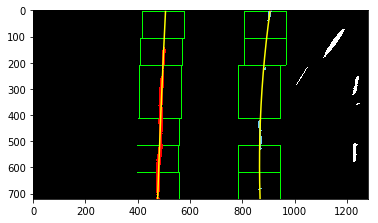

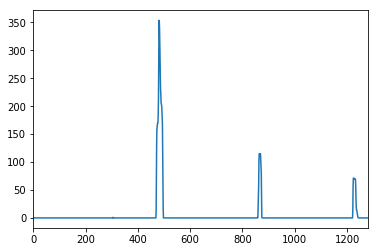

In [29]:
####################### Sliding Window Polyfit ############################
# Sliding Window Polyfit
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 7
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

# visualize the result on example image
exampleImg = cv2.imread('./test_images/test4.jpg')
exampleImg_bin = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.figure()
plt.plot(histogram)
plt.xlim(0, 1280)


(720, 0)

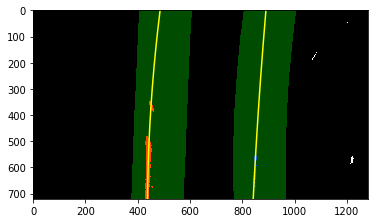

In [34]:
# Polyfit Using Fit from Previous Frame

# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2_bin = pipeline(exampleImg2)   
margin = 100

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [38]:
# Radius of Curvature and Distance from Lane Center Calculation

# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')



Radius of curvature for example: 4097.54367041 m, 402.181344061 m
Distance from lane center for example: -0.313749312132 m


...
...


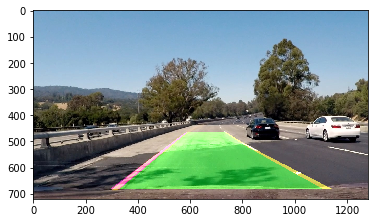

In [42]:
# Draw the Detected Lane Back onto the Original Image
def draw_lane(original_img, binary_img, l_fit, r_fit, M_inv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, M_inv)
plt.imshow(BRG2RGB(exampleImg_out1))
print('...')



...
...


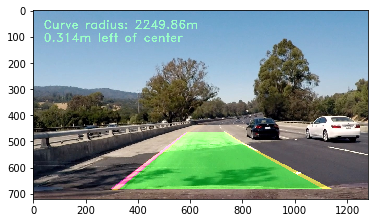

In [43]:
# Draw Curvature Radius and Distance from Center Data onto the Original Image
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(BRG2RGB(exampleImg_out2))
print('...')

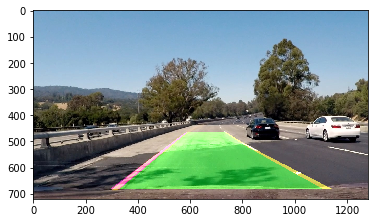

In [45]:
def process_image(image):
    bin_image = pipeline(image)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(bin_image)
    lanemarked_img = draw_lane(image, bin_image, left_fit, right_fit, M_inv)
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(bin_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
    data_img = draw_data(lanemarked_img, (rad_l+rad_r)/2, d_center)
    return lanemarked_img

test_lane = process_image(exampleImg)
plt.imshow(BRG2RGB(test_lane))
    